In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import warnings
warnings.filterwarnings("ignore")

#NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [3]:
questions= pd.read_csv('processed_data.csv')

#добавим столбец длины вопросов в датасет
questions['len_question'] = questions['question'].apply(lambda x: len(x))

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

corpus=[]
qst= questions['question'].str.split()
qst=qst.values.tolist()
corpus=[word for i in qst for word in i]

from collections import defaultdict
dic_stop_words={}
for word in corpus:
    if str(word).lower() in stopwords:
        if word in dic_stop_words: dic_stop_words[word]+=1
        else: dic_stop_words[word]=1

questions['qst_words'] = questions.question.apply(lambda x: x.split())
words_clean_all = list()
for words in questions.qst_words:
    words_clen = list()
    for w in words:
        if w.lower() not in dic_stop_words:
            words_clen.append(w.lower())
        words_clean_str = ' '.join(words_clen)
    words_clean_all.append(words_clean_str)

questions['qst_clean'] = words_clean_all
questions['len_qst_cln'] = questions['qst_clean'].apply(lambda x: len(x))

[nltk_data] Downloading package stopwords to /home/yana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
questions['year'] = questions['file'].apply(lambda row: int(row[-8:-4:]))

In [6]:
questions['qst_tokenised'] = questions['qst_clean'].apply(lambda x: word_tokenize(x))

In [7]:
def remove_punctuation(text):
    return [token for token in text if token not in string.punctuation and token not in ('‘', '’')]

questions['tokens_without_punctuationa'] = questions['qst_tokenised'].apply(remove_punctuation)

In [8]:
questions.head()

,file,page,question,score,target,len_question,qst_words,qst_clean,len_qst_cln,year,qst_tokenised,tokens_without_punctuationa
0,Question Paper - Unit 1 (WBS11) - January 2021...,2,Define the term ‘brand’ .,2,marketing mix and strategy,25,"[Define, the, term, ‘brand’, .]",define term ‘brand’ .,21,2021,"[define, term, ‘, brand, ’, .]","[define, term, brand]"
1,Question Paper - Unit 1 (WBS11) - January 2021...,2,Explain one risk Jack Ma may have taken when s...,4,entrepreneurs and leaders,74,"[Explain, one, risk, Jack, Ma, may, have, take...",explain one risk jack ma may taken setting ali...,57,2021,"[explain, one, risk, jack, ma, may, taken, set...","[explain, one, risk, jack, ma, may, taken, set..."
2,Question Paper - Unit 1 (WBS11) - January 2021...,3,Analyse two factors that may have increased de...,6,the market,73,"[Analyse, two, factors, that, may, have, incre...",analyse two factors may increased demand aliba...,55,2021,"[analyse, two, factors, may, increased, demand...","[analyse, two, factors, may, increased, demand..."
3,Question Paper - Unit 1 (WBS11) - January 2021...,4,Discuss if profit maximisation is the main bus...,8,entrepreneurs and leaders,83,"[Discuss, if, profit, maximisation, is, the, m...",discuss profit maximisation main business obje...,66,2021,"[discuss, profit, maximisation, main, business...","[discuss, profit, maximisation, main, business..."
4,Question Paper - Unit 1 (WBS11) - January 2021...,5,Assess the advantages of a paternalistic style...,10,managing people,102,"[Assess, the, advantages, of, a, paternalistic...",assess advantages paternalistic style leadersh...,72,2021,"[assess, advantages, paternalistic, style, lea...","[assess, advantages, paternalistic, style, lea..."


In [9]:
lem = WordNetLemmatizer()

def lemmatize(text):
    lem = WordNetLemmatizer()
    lemmatized_text = text

    for part_of_speech in ['n', 'v', 'a', 'r', 's']:
        lemmatized_text = [lem.lemmatize(token, part_of_speech).lower() for token in lemmatized_text]
    return lemmatized_text

questions['tokens_lemm'] = questions['tokens_without_punctuationa'].apply(lemmatize)
questions['tokens_lst'] = questions['tokens_without_punctuationa'].apply(lambda x: ' '.join(x))

In [10]:
questions['target'].unique()

array(['marketing mix and strategy', 'entrepreneurs and leaders',
       'the market', 'managing people', 'meeting customer needs',
       'unit 2', '?'], dtype=object)

In [11]:
def target_to_int(target):
    if target == 'marketing mix and strategy':
        return 1
    elif target == 'entrepreneurs and leaders':
        return 2
    elif target == 'the market':
        return 3
    elif target == 'managing people':
        return 4
    elif target == 'meeting customer needs':
        return 5
    else:
        return 6

In [12]:
questions['target_code'] = questions['target'].apply(target_to_int)
questions.head()

,file,page,question,score,target,len_question,qst_words,qst_clean,len_qst_cln,year,qst_tokenised,tokens_without_punctuationa,tokens_lemm,tokens_lst,target_code
0,Question Paper - Unit 1 (WBS11) - January 2021...,2,Define the term ‘brand’ .,2,marketing mix and strategy,25,"[Define, the, term, ‘brand’, .]",define term ‘brand’ .,21,2021,"[define, term, ‘, brand, ’, .]","[define, term, brand]","[define, term, brand]",define term brand,1
1,Question Paper - Unit 1 (WBS11) - January 2021...,2,Explain one risk Jack Ma may have taken when s...,4,entrepreneurs and leaders,74,"[Explain, one, risk, Jack, Ma, may, have, take...",explain one risk jack ma may taken setting ali...,57,2021,"[explain, one, risk, jack, ma, may, taken, set...","[explain, one, risk, jack, ma, may, taken, set...","[explain, one, risk, jack, ma, may, take, set,...",explain one risk jack ma may taken setting ali...,2
2,Question Paper - Unit 1 (WBS11) - January 2021...,3,Analyse two factors that may have increased de...,6,the market,73,"[Analyse, two, factors, that, may, have, incre...",analyse two factors may increased demand aliba...,55,2021,"[analyse, two, factors, may, increased, demand...","[analyse, two, factors, may, increased, demand...","[analyse, two, factor, may, increase, demand, ...",analyse two factors may increased demand aliba...,3
3,Question Paper - Unit 1 (WBS11) - January 2021...,4,Discuss if profit maximisation is the main bus...,8,entrepreneurs and leaders,83,"[Discuss, if, profit, maximisation, is, the, m...",discuss profit maximisation main business obje...,66,2021,"[discuss, profit, maximisation, main, business...","[discuss, profit, maximisation, main, business...","[discus, profit, maximisation, main, business,...",discuss profit maximisation main business obje...,2
4,Question Paper - Unit 1 (WBS11) - January 2021...,5,Assess the advantages of a paternalistic style...,10,managing people,102,"[Assess, the, advantages, of, a, paternalistic...",assess advantages paternalistic style leadersh...,72,2021,"[assess, advantages, paternalistic, style, lea...","[assess, advantages, paternalistic, style, lea...","[assess, advantage, paternalistic, style, lead...",assess advantages paternalistic style leadersh...,4


In [13]:
questions = questions[questions.target_code < 6]

In [14]:
questions['target_code'].unique()

array([1, 2, 3, 4, 5])

Разделим выборки на обучение и тест

In [15]:
X_questions = questions['tokens_lst']
y = questions['target_code']

BOW of trigrams

In [17]:
word_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', sublinear_tf=True, strip_accents='unicode',
                                  stop_words='english', ngram_range=(1, 1), max_features=10000)
word_vectorizer.fit(X_questions)

train_word_features = word_vectorizer.transform(X_questions)

In [18]:
char_vectorizer = TfidfVectorizer(analyzer='char', sublinear_tf=True, strip_accents='unicode',
                                  stop_words='english', ngram_range=(1, 3), max_features=50000)
char_vectorizer.fit(X_questions)

train_char_features = char_vectorizer.transform(X_questions)

In [19]:
from scipy.sparse import hstack

train_features = hstack([train_word_features, train_char_features])

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from time import time

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train_features, y,test_size=0.3 ,random_state=42)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

print("Train Data Size: ",y_train.shape)
print("Test Data Size: ",y_test.shape)

Train Data Size:  (168, 3081)
Test Data Size:  (73, 3081)
Train Data Size:  (168,)
Test Data Size:  (73,)


In [24]:
lr_model = LogisticRegression(random_state=42)
param_dict = {'C': [0.001, 0.01, 0.1, 1, 10],
             'solver': ['sag', 'lbfgs', 'saga'],
             'penalty':['l1','l2']}

start = time()
grid_search = GridSearchCV(lr_model, param_dict)
grid_search.fit(X_train, y_train)
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(grid_search.best_params_)
print("Cross-Validated Score of the Best Estimator: %.3f" % grid_search.best_score_)

GridSearch took 12096.86 seconds to complete.


{'C': 10, 'penalty': 'l2', 'solver': 'saga'}

Cross-Validated Score of the Best Estimator: 0.774


РАСПИСАТЬ ПАРАМЕТРЫ

Наилучшее качество при параметрах {'C': 10, 'penalty': 'l2', 'solver': 'saga'}

solver = saga 

In [156]:
lr=LogisticRegression(C=10, solver='saga', penalty='l2')
lr.fit(X_train, y_train)
lr_preds=lr.predict(X_test)

print(classification_report(y_test, lr_preds))
print("Accuracy Score: %.3f" % accuracy_score(y_test, lr_preds))

              precision    recall  f1-score   support

           1       0.74      0.77      0.76        22
           2       1.00      0.50      0.67         6
           3       1.00      0.75      0.86         8
           4       0.75      0.38      0.50         8
           5       0.70      0.90      0.79        29

    accuracy                           0.75        73
   macro avg       0.84      0.66      0.71        73
weighted avg       0.78      0.75      0.74        73

Accuracy Score: 0.753


Наилучшее каечство f1-меры - 0,86 для предсказания 3 класса

In [172]:
from sklearn.metrics import auc, roc_curve, average_precision_score

In [189]:
lr_preds_reshaped = lr_preds.reshape(-1, 1)
average_precision_score(y_test, lr_preds_reshaped)

np.float64(0.2580759692353411)

In [193]:
fpr = {}
tpr = {}
thresh = {}

for i in range(1,6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, lr_preds, pos_label=i)

In [194]:
for i in range(1,6):
    print(auc(fpr[i], tpr[i]))

0.18315508021390375
0.43781094527363185
0.4826923076923077
0.4932692307692308
0.8079937304075235


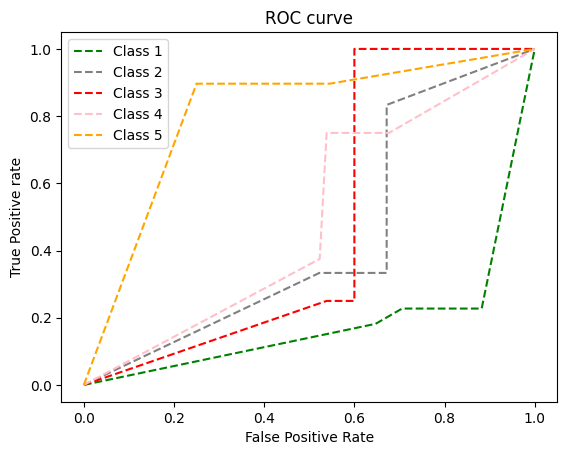

In [195]:
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1')
plt.plot(fpr[2], tpr[2], linestyle='--',color='grey', label='Class 2')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3')
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Class 4')
plt.plot(fpr[5], tpr[5], linestyle='--',color='orange', label='Class 5')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

SVC

In [198]:
from sklearn.svm import SVC 
svc = SVC() 
svc.fit(X_train, y_train) 
svc_preds=svc.predict(X_test)

print(classification_report(y_test, svc_preds))
print("Accuracy Score: %.3f" % accuracy_score(y_test, svc_preds))

              precision    recall  f1-score   support

           1       1.00      0.32      0.48        22
           2       0.00      0.00      0.00         6
           3       1.00      0.62      0.77         8
           4       1.00      0.12      0.22         8
           5       0.48      1.00      0.65        29

    accuracy                           0.58        73
   macro avg       0.70      0.41      0.43        73
weighted avg       0.71      0.58      0.51        73

Accuracy Score: 0.575


In [199]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

start = time()
grid_search = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
grid_search.fit(X_train, y_train) 
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(grid_search.best_params_)
print("Cross-Validated Score of the Best Estimator: %.3f" % grid_search.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.382 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.382 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.382 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.394 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.394 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.382 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.382 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.382 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.394 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.394 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.382 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Cross-Validated Score of the Best Estimator: 0.744


In [200]:
svc_pred = grid_search.predict(X_test) 

print(classification_report(y_test, svc_pred)) 
print("Accuracy Score: %.3f" % accuracy_score(y_test, svc_pred))

              precision    recall  f1-score   support

           1       0.68      0.77      0.72        22
           2       0.67      0.67      0.67         6
           3       1.00      0.75      0.86         8
           4       0.33      0.12      0.18         8
           5       0.70      0.79      0.74        29

    accuracy                           0.70        73
   macro avg       0.68      0.62      0.63        73
weighted avg       0.68      0.70      0.68        73

Accuracy Score: 0.699


In [204]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'criterion':['gini','entropy'],
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

start = time()
tree_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5) 
tree_grid_search.fit(X_train, y_train) 
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(tree_grid_search.best_params_)
print("Cross-Validated Score of the Best Estimator: %.3f" % tree_grid_search.best_score_)

GridSearch took 3.74 seconds to complete.


{'criterion': 'entropy', 'max_depth': 15}

Cross-Validated Score of the Best Estimator: 0.661


In [206]:
tree_pred = tree_grid_search.predict(X_test) 

print(classification_report(y_test, tree_pred)) 
print("Accuracy Score: %.3f" % accuracy_score(y_test, tree_pred))

              precision    recall  f1-score   support

           1       0.43      0.45      0.44        22
           2       0.67      0.33      0.44         6
           3       1.00      0.62      0.77         8
           4       0.22      0.25      0.24         8
           5       0.58      0.66      0.61        29

    accuracy                           0.52        73
   macro avg       0.58      0.46      0.50        73
weighted avg       0.55      0.52      0.52        73

Accuracy Score: 0.521


Качество на деревьях хуже всего - 0,521, почти рандом